## The Context
[Augmented Reality](https://en.wikipedia.org/wiki/Augmented_reality) is a way of stitching together the virtual and real worlds.

If we have enough information about a camera, we can render virtual imagery and then composite it with captured imagery of the real world. In particular, we need information about the camera's intrinsic matrix (K) and its extrinsic matrix, which contains information about its position and attitude in the real world.


To keep things simple, I will use this chessboard-style calibration pattern to orient the pattern. The advantage of using this type of pattern is that we can accurately measure the position of each corner at the intersection between white and black squares.

![](https://cgcooke.github.io/Blog//images/2021-02-17-An-Introduction-To-Augemented-Reality/chessboard.jpg)


## The Code
As always, let's start by importing what we need.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as Rot
from warnings import filterwarnings
filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (10,10)

I've already calibrated the camera, which means we have both the camera matrix (K) and the camera's distortion parameters.

In [2]:
K = np.array([[3286.9, 0.0 , 2032.8],
              [0.0   , 3282.3, 1519.1],
              [0.0   , 0.0   ,    1.0]])

dist = np.array([[2.44663616e-01],[-1.48023303e+00],[2.04607109e-03],[1.53484564e-03],[2.56349651e+00]])

Let's now load the image and find the corners.

In [3]:
fname = 'data/2021-02-17-An-Introduction-To-Augemented-Reality/chessboard.jpg'
img = cv2.imread(fname)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# Find the chess board corners
ret, points_2d = cv2.findChessboardCorners(gray, (9,6),None)

#Refine the position of the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
points_2d_precise = cv2.cornerSubPix(gray,points_2d,(11,11),(-1,-1),criteria)

Let's now visualise the corners that we found.

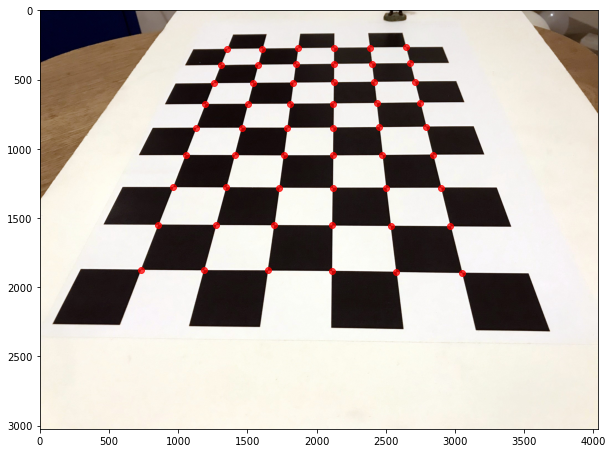

In [4]:
points_2d_precise = np.squeeze(points_2d_precise)
plt.imshow(img[:,:,::-1])
plt.scatter(points_2d_precise[:,0],points_2d_precise[:,1], color='r', alpha=0.75)
plt.show()

We also know the 3D location of the points in the corners because it is a flat grid.

In [5]:
# Create a grid of points
points_3d = np.zeros((6*9,3), np.float32)
points_3d[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Put everything in the correct shape
points_3d = np.expand_dims(points_3d,2)
points_2d_precise = np.expand_dims(points_2d_precise, 2)

Using the point correspondences and the camera's intrinsic parameters, we can solve to find the relationship between the camera's coordinate frame and the world's coordinate frame.

![](https://cgcooke.github.io/Blog//images/2021-02-17-An-Introduction-To-Augemented-Reality/pinholeCamera.png)

In this case, *rvec* is in [Rodrigues](https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula) format.

In [6]:
ret, rvec, tvec = cv2.solvePnP(points_3d, points_2d_precise, K, dist)

In [7]:
print(rvec)

[[-0.63902069]
 [-0.59625232]
 [-1.46556394]]


In [8]:
print(tvec)

[[-2.83521712]
 [ 0.77473203]
 [ 7.22217967]]


Let's now visualise the X, Y and Z axis overlayed on top of our image.
Note that the Z-axis, in this case, is going down into the table.

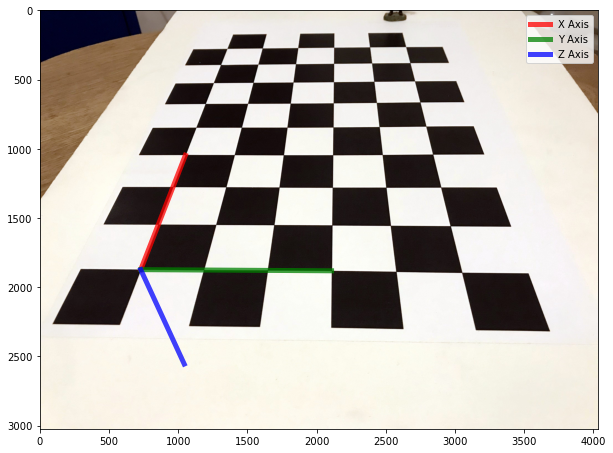

In [9]:
# project 3D points to image plane
axis = np.float32([[3,0,0], [0,3,0], [0,0,3]]).reshape(-1,3)
imgpts, jac = cv2.projectPoints(axis, rvec, tvec, K, dist)
imgpts = np.squeeze(imgpts)

plt.imshow(img[:,:,::-1])
plt.plot([points_2d_precise[0,0],imgpts[0,0]],[points_2d_precise[0,1], imgpts[0,1]], color='r', alpha=0.75, linewidth=5, label='X Axis')
plt.plot([points_2d_precise[0,0],imgpts[1,0]],[points_2d_precise[0,1], imgpts[1,1]], color='g', alpha=0.75, linewidth=5, label='Y Axis')
plt.plot([points_2d_precise[0,0],imgpts[2,0]],[points_2d_precise[0,1], imgpts[2,1]], color='b', alpha=0.75, linewidth=5, label='Z Axis')

plt.legend()
plt.show()

We have both the rotation, and the translation, which transform points from the world frame to the camera frame. From this, we can find the camera's location in the world (*Camera_C*) and orientation with respect to the world frame (*Camera_R*).

In [10]:
r = Rot.from_rotvec(rvec[:,0])
R = r.as_matrix()
t = np.array(tvec)

We can see that the camera is located at (-4.5, 3, -5.5) units (grid squares).

In [11]:
Camera_C = -np.dot(R.T,tvec)
print(Camera_C)

[[-4.52503556]
 [ 3.05060167]
 [-5.56923942]]


Now let's find its orientation as a quaternion.

In [12]:
Camera_R = Rot.from_matrix(R.T).as_quat()
print(Camera_R)

[0.2821332  0.26325059 0.64705923 0.65758219]


## The Results

Given that we have both intrinsic and extrinsic parameters,  we can render images using *Blender*, using the same set of parameters. Then we can composite the synthetically rendered objects back into the original photograph. This results in a convincing illusion, which forms the basis for Augmented Reality.

![](https://cgcooke.github.io/Blog//images/2021-02-17-An-Introduction-To-Augemented-Reality/Render.jpg)



![](https://cgcooke.github.io/Blog//images/2021-02-17-An-Introduction-To-Augemented-Reality/AR.jpg)